# nbed library: Peak detection example
L. Houben, Weizmann Institute of Science
last updated April 2024

- Load a 4D STEM nanobeam diffraction data set.
  This script uses a data set that can be downloaded from https://doi.org/10.5281/zenodo.15212905
- Inspect a frame.
- Compensate residual descan shifts.
- Adjust peak detection parameters in a subset of frames.
- Run peak detection on all frames.
- Create a Debye-Scherrer type plot
- Create a peak distance histogram ('powder plot')

In [1]:
import numpy as np
import numpy.matlib
#from objbrowser import browse
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pims
import trackpy as tp
# for animated view
import time
from IPython import display
%matplotlib inline
import os
# load nbed module and helper routines
# possibly installed under miniforge3/envs/py4Dstem/lib/python3.9/site-packages
import nbed
from nbed import ParabolaFit2D,bytscl

## Define filename, create class instance, load the data set, and display a single frame 
Currently supported formats: 
- PantaRhei .prz (default)
- EMPAD .raw

In [2]:
# Path definition and filename
path="/Users/houben/Downloads/"
filebasename="Coccolithophore0025"
filesuffix="prz"

In [3]:
# create an instance of the pyNBED module and load data
myset=nbed.pyNBED()
myset.LoadFile(path+filebasename+'.'+filesuffix)

pyNBED: Loading object descriptor: /Users/houben/Downloads/Coccolithophore0025.prz
pyNBED: Loading data ...
        finished
pyNBED: array dimensions: (217, 256, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


In [4]:
# There is a docstring for the methods in the pyNBED module, here is how you can display it
myset.LoadFile?

Signature: myset.LoadFile(fname, type='PantaRhei')
Docstring:
Load a 4D STEM dataset  

Parameters:
fname:   complete filename including path and suffix
type:    'PantaRhei' or 'EMPAD' [default: PantaRhei]

Returns:

void
File:      ~/Tyche/git/nbed/src/nbed/classes/pyNBED.py
Type:      method

frame coordinates: 174 94
frame dimensions:  (256, 256)


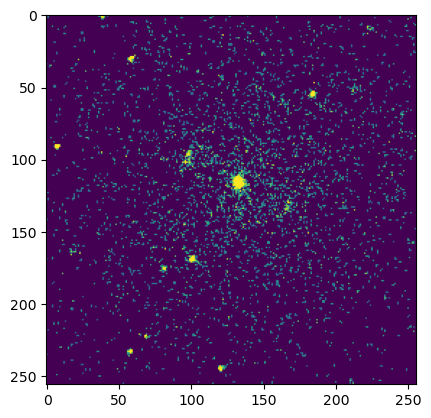

In [5]:
# Display a single frame at row 174, column 94
frame=myset.ShowFrame(i=174, j=94,Log=True, sd=6)

## Find central diffraction peak locations and compensate the displacement
The data held by the class instance will be updated and hold the aligned frames. <br>
A second execution will display the residual displacements after correction with a second order polynomial.

locating strongest pixel in all frames ...
finished


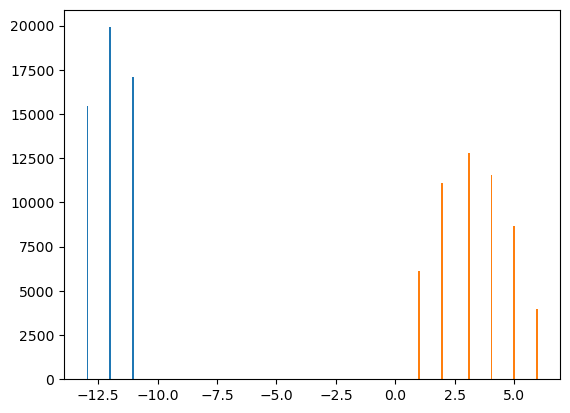

Displacement statistics along x, filtered for outliers (all indices):
Mean =  -11.971085213464224 ( -11.956221198156681 )
Max  =  -11 ( -9 )
Min  =  -13 ( -14 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  3.3016820713014523 ( 3.264832949308756 )
Max  =  6 ( 7 )
Min  =  1 ( 0 )


<Figure size 640x480 with 0 Axes>

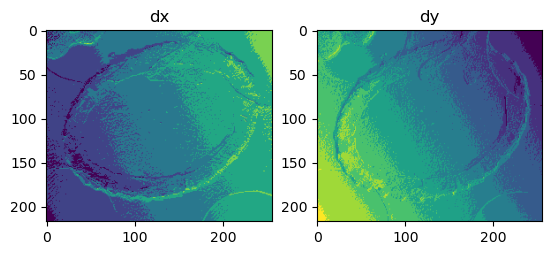

In [6]:
# obtain displacements
(dx,dy)=myset.DiffractionShift(reject_sd=2, searchradius=20)

(55552,)


<Figure size 640x480 with 0 Axes>

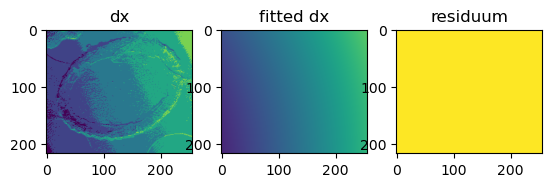

Residuum statistics dx-dxfit
Mean deviation:     2.686023446673766e-16
Max abs deviation:  3.4564934238318887
Mean abs deviation: 0.3370847595316985
(55552,)


<Figure size 640x480 with 0 Axes>

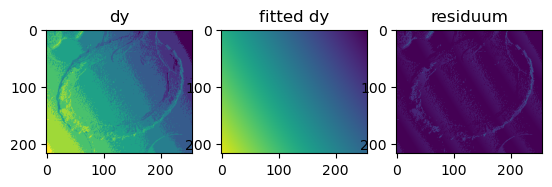

Residuum statistics dy-dyfit
Mean deviation:     -5.833535748670101e-10
Max abs deviation:  2.7902017276734163
Mean abs deviation: 0.35053075660262695
finished


In [7]:
# compensate shifts pixel-wise
myset.CompensateShift(dx,dy)

locating strongest pixel in all frames ...
finished


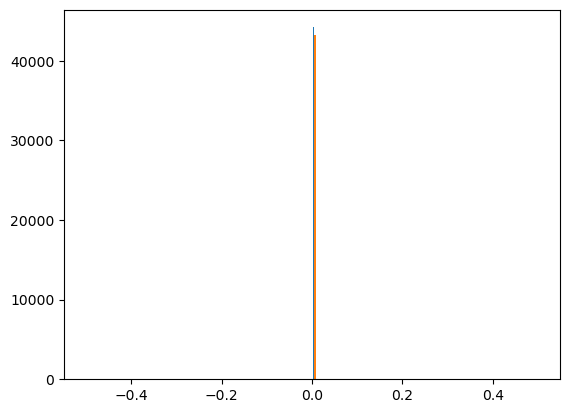

Displacement statistics along x, filtered for outliers (all indices):
Mean =  0.0 ( 0.007848502304147466 )
Max  =  0 ( 3 )
Min  =  0 ( -3 )
Displacement statistics along y, filtered for outliers (all indices):
Mean =  0.0 ( 0.002376152073732719 )
Max  =  0 ( 3 )
Min  =  0 ( -3 )


<Figure size 640x480 with 0 Axes>

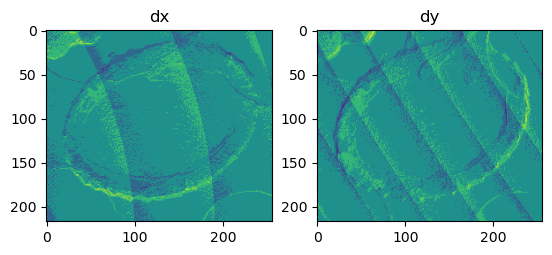

In [8]:
# check that the correction worked and display the residual displacement statistics 
# the residuum shows the com shift corrected for the low-order descan shift
# steps in the residuum are integer truncation remainders due to the pixel-wise shift
(dx,dy)=myset.DiffractionShift(reject_sd=2, searchradius=20)

## Create a virtual aperture image



In [9]:
# Create a virtual detector image
# this may take some time due to single-core processing
myset.VirtualApertureImage?

Signature: myset.VirtualApertureImage(radius=[0, 10], offset=None, invert=False)
Docstring:
Create a virtual detector image with a disk-like aperture

Parameters:
radius:    inner and outer radius of the aperture in pixels [default:[0,10]]
offset:    optional displacement from the center in pixels [default: None]
           offset=[20,100] shifts the aperture mask 20 pixels horizontally and 100 pixels vertically
invert:    invert the aperture mask, e.g. to create a dark-field image instead of a bright-field image

Notes: 

the mask will span the range [iradius,oradius[
the computational effort is proportional to the number of pixels in the mask

Examples: 

BF detector - radius=[0,radius] of the bright field mask, invert=False
DF detector - radius=[0,100], invert=True
annular DF detector - radius=[50,100], invert=False

Returns:

(mask, image) 2D arrays, dtype np.float64
File:      ~/Tyche/git/nbed/src/nbed/classes/pyNBED.py
Type:      method

In [10]:
# create a virtual detector image
(mask, vimage)=myset.VirtualApertureImage(radius=[20,100],offset=[0,0],invert=False)

/Users/houben/Tyche/git/nbed/src/nbed/helpers.py:104: RuntimeWarning: invalid value encountered in cast
  img8bit[img < vmin]=vmin


<Figure size 640x480 with 0 Axes>

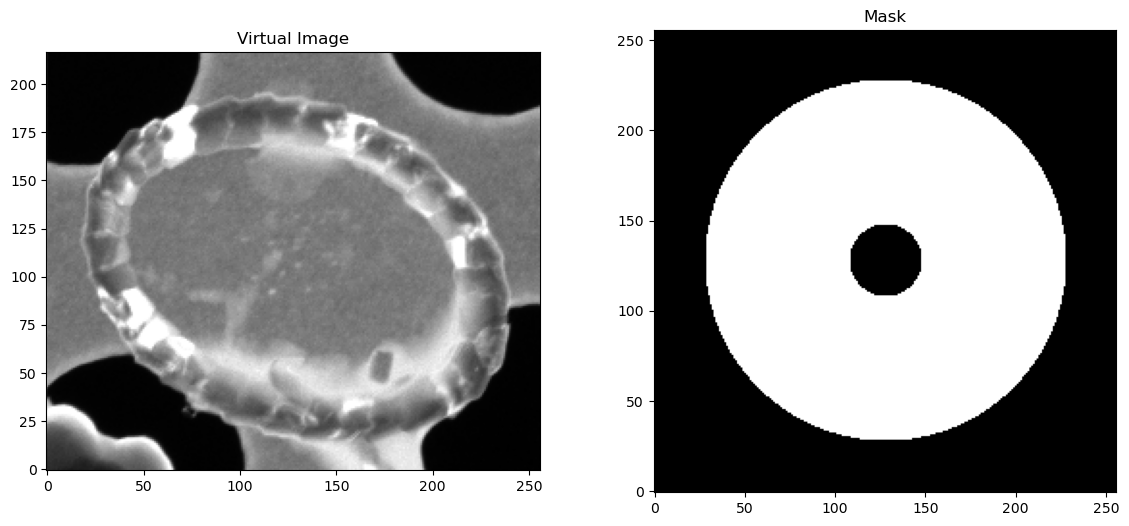

In [11]:
# plot the image
plt.figure()

#subplot(r,c) provide the no. of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax1.imshow(bytscl(vimage,vmin=np.mean(vimage)-2*np.std(vimage),vmax=np.mean(vimage)+2*np.std(vimage)),cmap='gray',origin="lower") 
ax1.set_title('Virtual Image')
ax2.imshow(mask,cmap='gray',origin="lower")
ax2.set_title('Mask')
plt.show()

## Preparation step for the peak Detection
Prepare a preset for the detection parameters.
These parameters are detector-dependent, nbed has presets for DECTRIS counting detectors and the EMPAD detector.

In [12]:
# retrieve default peak detection parameters for the Dectris ELA detector 
pars=myset.PreparePeakDetectionPars(shortcut='ELA')

In [13]:
# report parameters
for key,value in pars.items():
    print(key,": ", value)

feature_size :  7
feature_minmass :  2.0
feature_separation :  8
feature_percentile :  65.0
feature_threshold :  1.0
noise_size :  1.0
smooth_size :  None
frame_cmin :  1.0
frame_cmax :  10.0
frame_cutoff :  0.0
conv2D :  True


In [14]:
# adapt parameters, setting conv2D to False speeds up processing
pars["feature_minmass"]=10
pars["feature_threshold"]=3
pars["conv2D"]=False
pars["frame_cmax"]=10.

## Peak detection
Detect peaks in a sub-region. The Peak detection method uses a 1D index array for addressing the spatial pixels. The method LinearIndexArray converts the 2D coordinate ranges into a 1D array. 

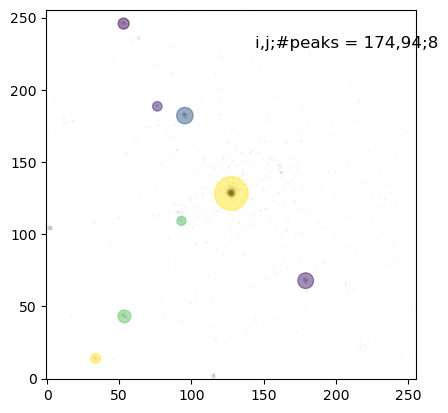

In [15]:
# define region of interest - columns=horizontal axis, rows=vertical axis
cols=np.arange(170,175)
rows=np.arange(85,95)
# Linearize frame indices
indcs=myset.LinearIndexArray(cols,rows,is_roi=True)
# detect peaks in region of interest
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=True)

Detect peaks in the full frame. Skip graphical output.

In [16]:
# run peak search on all frames
# this may take a little while
rows=np.arange(0,myset.dim[0])
cols=np.arange(0,myset.dim[1])
indcs=myset.LinearIndexArray(rows,cols,is_roi=True)
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=False)

Processing Frames : 100%|███████████████████████████████████| 55552/55552 [12:59<00:00, 71.31it/s]


In [17]:
# The peaklist is an array of dictionaries
# show the peak data for the frame at coordinate (175,95)
# peak coordinates are in pixel units
i=175
j=95
frameno=i*myset.dim[1]+j
framepeaklist[frameno]

{'i': np.int64(175),
 'j': np.int64(95),
 'x': array([ -0.56033376,  33.68493151, -32.96507937,  50.43956044,
        -51.97928994, -74.63076923, -75.94600432]),
 'y': array([  0.22528883,  18.15525114,  53.78253968, -60.15855573,
         60.19822485, -84.96923077, 117.94168467]),
 'q': array([  0.60392796,  38.26601305,  63.08136042,  78.50605763,
         79.53409871, 113.09076838, 140.27842512]),
 'mass': array([1111.68250742,   78.1317295 ,  224.76250952,  227.25987074,
         120.58687019,  139.13869637,  165.18260621]),
 'size': array([1.71286006, 1.35989524, 1.43924583, 1.49567666, 1.17920844,
        1.32819523, 1.24181989]),
 'raw_mass': array([3661.,  243.,  527.,  539.,  282.,  302.,  353.])}

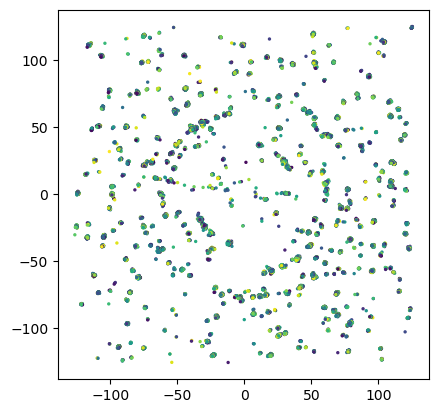

In [18]:
# produce a scatterplot - Debye-Scherrer plot - from all frames
# filter peaks with a raw electron count >= 200
# refine the center for each frame, this produces the sub-pixel precision
(qx,qy)=myset.DebyeScherrerPlot(framepeaklist, refine=True, massthresh=200)

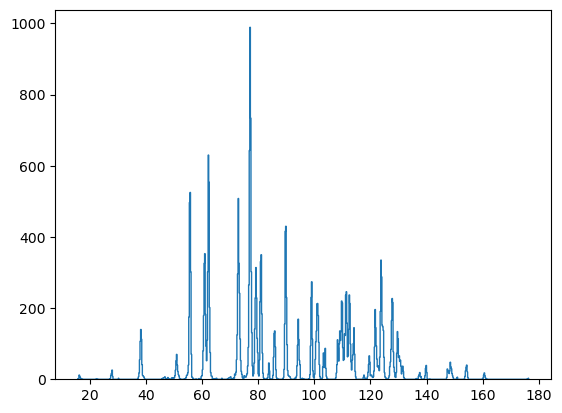

In [19]:
# produce a peak distance histogram - a type of powder diffraction - from all frames
# filter peaks with a raw electron count >= 200
# refine the center for each frame, this produces the sub-pixel precision
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=True, massthresh=500)